#  Exercise Set 1: Introduction to modeling and machine learning



In [8]:
"""
Implementing the following classifiers:
- Perceptron
- Adaline
- Linear Regression
- Logistic Regression
"""

import numpy as np


class Classifier:
    """
    Superclass for classifiers.
    TODO Either force y to have (n, 1) shape or throw error if (n,).
    """

    def __init__(self, eta=0.1, N=100, w=None):
        if eta <= 0 or eta > 1:
            raise ValueError("Learning rate eta must be between 0 and 1")

        self.eta = eta
        self.N = N
        self.w = w
        self.errors = []

    def activation(self, X):
        return X

    def z(self, X):
        """
        Weighted sum of x by w.
        """
        return X @ self.w

    def predict(self, X):
        return np.where(self.activation(self.z(X)) >= 0.0, 1, -1)

    def _add_const(self, X):
        """
        This wastes some memory storing a lot of 1's,
        but make the code below easier to read.
        Call it "pedagogical" to get away with it.
        """
        x0 = np.ones(shape=(X.shape[0], 1))
        return np.hstack((x0, X))

    def _init_fit(self, X):
        nrows, ncols = X.shape

        # Add a constant as the first column
        X = self._add_const(X)

        self._init_w(ncols)

        return X, nrows, ncols

    def _init_w(self, size):
        # Initialize weights if not given
        # Add 1 to size to account for the ones added above
        # TODO generalize
        if self.w is None:
            self.w = np.random.normal(loc=0, scale=0.01, size=(size + 1, 1))


class Perceptron(Classifier):
    """
    The Perceptron classifier.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def activation(self, x):
        return 1 if x > 0 else -1

    def fit(self, X, y):
        # TODO think nrows, ncols are superfluous returns
        X, nrows, ncols = self._init_fit(X)

        for _ in range(self.N):
            errors = 0
            for xi, yi in zip(X, y):
                error = yi - self.predict(xi)
                dw = self.eta * error * xi
                self.w += dw.reshape((len(dw), 1))
                errors += error != 0.0

            self.errors.append(errors)
        return self


class Adaline(Classifier):
    """
    Adaptive Linear Neuron Classifier.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def fit(self, X, y):
        # TODO think nrows, ncols are superfluous returns
        X, nrows, ncols = self._init_fit(X)

        self.cost_ = list()

        for _ in range(self.N):
            error = y - self.activation(self.z(X))

            # This is just the gradient of J(w) now
            dw = self.eta * error.T @ X
            self.w += dw.T
            cost = 0.5 * (error ** 2).sum()
            self.cost_.append(cost)

        return self


class LinearRegression(Classifier):
    """
    Linear Regression classifier
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def _init_w(self, size):
        self.w = np.zeros((size + 1, 1))

    def _error(self, X, y):
        return y - self.activation(self.z(X))

    def fit(self, X, y):
        """
        Fit model using Linear Regression
        """
        X, nrows, ncols = self._init_fit(X)

        self.mse = []

        for _ in range(self.N):
            error = self._error(X, y)
            dw = self.eta * error.T @ X
            self.w += dw.T
            mse = 0.5 * (error ** 2).sum()
            self.mse.append(mse)

        return self


class LogisticRegression(Classifier):
    def __init__(self, **kwargs):
        raise NotImplementedError


[[ 0.02926135]
 [ 0.02156872]
 [ 0.07600778]
 [-0.10161191]
 [-0.04819713]]
[2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


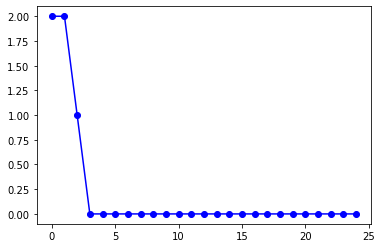

In [12]:
import importlib
import pandas as pd
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

iris = datasets.load_iris()
names = ["Class"] + iris.feature_names
df = pd.DataFrame(np.hstack((iris.target.reshape(len(iris.data), 1), iris.data)), columns = names)
df = df[df.Class <= 1]
df.Class = df.Class.apply(lambda x: 1 if x == 0.0 else -1)

p = Perceptron(eta = 0.01, N = 25)
p.fit(df.drop("Class", axis = 1).to_numpy(), df.Class.to_numpy())
print(p.w)
print(p.errors)
plt.plot(p.errors, 'b-o') 

# Beyond the perceptron model

Having seen and worked with the perceptron I want to provide you with some ideas on how we can change parts of the perceptron to obtain another model. Again, you may want to familiarize yourself with background concepts: [gradient](https://en.wikipedia.org/wiki/Gradient), [sum of squared errors](https://en.wikipedia.org/wiki/Residual_sum_of_squares) and the [sigmoid function](https://en.wikipedia.org/wiki/Sigmoid_function).

## Logistic regression 

Logistic regression is another simple linear machine-learning algorithm, you can read about it [here:](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression)


> **Ex. 1.2.1:** Import the LogisticRegression classifier from `sklearn.linear_model`. Create a new object called `clf` like:
```
clf = LogisticRegression()
```
All scikit learn models have two fundamental methods `.fit()` and `.predict()`. Fit your model to the training data, and store the fitted model in a new object. Import _accuracy_score_ from `sklearn.metrics` and asses the accuracy of the LogisticRegression on both your training data and your test data.

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import accuracy_score

iris = datasets.load_iris()
names = ["Class"] + iris.feature_names
df = pd.DataFrame(np.hstack((iris.target.reshape(len(iris.data), 1), iris.data)), columns = names)
df = df[df.Class <= 1]
df.Class = df.Class.apply(lambda x: 1 if x == 0.0 else -1)
clf = LogisticRegression()
X = df.drop("Class", axis = 1).to_numpy()
y = df.Class.to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

fitted = clf.fit(X_train, y_train)
ypred = fitted.predict(X_train)
print(accuracy_score(y_train, fitted.predict(X_train)))
print(accuracy_score(y_test, fitted.predict(X_test)))


1.0
1.0


# Linear regression mechanics
### Implementing and evaluating the gradient decent 
 
Normally we use OLS to estimate linear regression models, but this is only way of solving the problem of minimizing the least squares problem (that minimizes the sum of squared errors). 

You may find PML pp. 310-312, 319-324 useful as background reading.

We continue straight to an exercise where you are to implement a new estimator that we code up from scratch. We solve the numerical optimization using the gradient decent algorithm. Using our algorithm we will fit it to some data, and compare our own solution to the standard solution from `sklearn`

> **Ex. 11.1.0**: Import the dataset `tips` from the `seaborn`.


*Hint*: use the `load_dataset` method in seaborn

In [5]:
df = sns.load_dataset("tips")
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


> **Ex. 11.1.1**: Convert non-numeric variables to dummy variables for each category (remember to leave one column out for each catagorical variable, so you have a reference). Restructure the data so we get a dataset `y` containing the variable tip, and a dataset `X` containing the 
features. 

>> *Hint*: You might want to use the `get_dummies` method in pandas, with the `drop_first = True` parameter. 

In [22]:
df = pd.get_dummies(df, drop_first = True)
target = "tip"
X = df.drop(target, axis = 1)
y = df[target]

> **Ex. 11.1.2**: Divide the features and target into test and train data. Make the split 50 pct. of each. The split data should be called `X_train`, `X_test`, `y_train`, `y_test`.

>> *Hint*: You may use `train_test_split` in `sklearn.model_selection`.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=0)

> **Ex. 11.1.3**: Normalize your features by converting to zero mean and one std. deviation.

>> *Hint 1*: Take a look at `StandardScaler` in `sklearn.preprocessing`. 

>> *Hint 2*: If in doubt about which distribution to scale, you may read [this post](https://stats.stackexchange.com/questions/174823/how-to-apply-standardization-normalization-to-train-and-testset-if-prediction-i).

In [25]:
s = StandardScaler()
X_train_prep = s.fit_transform(X_train)
X_test_prep = s.transform(X_test)

> **Ex. 11.1.4**: Make a function called `compute_error` to compute the prediction errors given input target `y_`, input features `X_` and input weights `w_`. You should use matrix multiplication.
>
>> *Hint 1:* You can use the net-input fct. from yesterday.
>>
>> *Hint 2:* If you run the following code,
>> ```python
y__ = np.array([1,1])
X__ = np.array([[1,0],[0,1]])
w__ = np.array([0,1,1])
compute_error(y__, X__, w__)
```

>> then you should get output:
```python 
array([0,0])
```



In [38]:
def compute_error(y, X, w):
    return y - (w[0] + X @ w[1:])

# Test

y__ = np.array([1,1])
X__ = np.array([[1,0],[0,1]])
w__ = np.array([0,1,1])
e = compute_error(y__, X__, w__)
assert np.all((e == 0))


array([0, 0])

> **Ex. 11.1.5**: Make a function to update the weights given input target `y_`, input features `X_` and input weights `w_` as well as learning rate, $\eta$, i.e. greek `eta`. You should use matrix multiplication.

In [92]:
def update(y, X, w, eta = 0.001):
    y = np.reshape(y, (X.shape[0], 1))
    error = y - (w[0] + X @ w[1:])
    w[0] += eta * np.sum(error)
    w[1:] += eta * (X.T @ error)
    return w, error

w = np.zeros(1 + X.shape[1]).reshape((5, 1))
w, error = update(y_train, X_train, w, eta = 0.001)

> **Ex. 11.1.6**: Use the code below to initialize weights `w` at zero given feature set `X`. Notice how we include an extra weight that includes the bias term. Set the learning rate `eta` to 0.001. Make a loop with 50 iterations where you iteratively apply your weight updating function. 

>```python
w = np.zeros(1+X.shape[1])
```

In [95]:
w = np.zeros(1 + X.shape[1]).reshape((5, 1))

for i in range(50):
    w, err = update(y_train, X_train, w)

print(w)

[[17278735.41312099]
 [96639124.79532792]
 [53504322.09872471]
 [53872766.05374784]
 [15208800.45602682]]


> **Ex. 11.1.7**: Make a function to compute the mean squared error. Alter the loop so it makes 100 iterations and computes the MSE for test and train after each iteration, plot these in one figure. 

>> Hint: You can use the following code to check that your model works:
>>```python
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(X_train, y_train)
assert((w[1:] - reg.coef_).sum() < 0.01)
```

In [21]:
# [Answer to Ex. 11.1.7]

The following bonus exercises are for those who have completed all other exercises until now and have a deep motivation for learning more.

> **Ex. 11.1.8 (BONUS)**: Implement your linear regression model as a class.

> ANSWER: A solution is found on p. 320 in Python for Machine Learning.

## AdaLine (BONUS)
AdaLine is a modified version of the perceptron. The only difference lies in the way the two models learn from their training data, i.e. the optimization method used. The perceptron used the binary classifications for learning, while AdaLine only applies the binary threshold after training, and thus uses real valued numbers when learning. 
>> _Hint:_ Most of the code for this exercise can be written by copying and modifying code from exercise 1.1.

> **Ex. 1.3.1 (BONUS):** Implement two functions described below. You shold reuse your `net_input` from Ex. 1.1.4.:
* `ada_activation_function`: the identify function $ada\_activation(z) = z$
* `ada_predict`: A step function   $ada\_predict(z) = 1 \ if \ z \geq 0  \ else \ 0$ where z is the output of _the activation function_.



> The following figure might help you understand how each of these functions relate to the algorithm, and how the perceptron and adaline differ:
![asd](https://sebastianraschka.com/images/faq/diff-perceptron-adaline-neuralnet/4.png)

In [ ]:
# [Answer to Ex. 1.3.1 BONUS]

> **Ex. 1.3.2 (BONUS):** AdaLine uses a _cost function_ to quantize the accuracy of the classifier this is given by 
>$$ 
cost(X,y,W) = \frac{1}{2} \sum_{i=1}^N (y_i - activation(z_i) )^2 , \qquad z_i = net\_input(x_i, W)
$$
> If you've followed any normal undergraduate courses in statistics you should recognize this function. Begin by implementing the cost function. Unlike in undergraduate statistics we will optimize our estimator using gradient descent, therefore **code up the negative of the derivative of the cost function as well**. 
> $$ 
-cost'_j(X,y, W) = -\sum_{i=1}^N (y_i - activation(z_i)) x_i^j,  \qquad z_i = net\_input(x_i, W)
$$
>
>> _Hint:_ Dont compute the sum for each weight $w_j$, instead use numpy's matrix algebra to compute the all of the derivatives at once.
>
>> _Hint:_ The derivative should return a list of the same length as the number of weights, since there is one derivative for each one.

In [ ]:
# [Answer to Ex. 1.3.2 BONUS]

> **Ex. 1.3.3 BONUS:** Implement the adaline fitting algorithm using *batch gradient descent*. This is similar to what you did with the perceptron, but while the perceptron did it's optimization after evaluating each row in the dataset, adaline treats the entire dataset as a batch, adjusts it's weights and then does it all again. Thus you only need to loop over `n_iter`, _not_ the data rows. Use the cost function to track the progress of your algorithm.
>
>> _Hint:_ gradient descent will be extremely sensitive to the learning rate $\eta$ in this situation - try setting i to 0.0001 and running the algorithm for 5000 iterations to get some kind of convergence.


In [ ]:
# [Answer to ex. 1.3.3 BONUS]

> **Ex. 1.3.4 (BONUS):** Write a function that scales each of the variables in the dataset (including **y**) using the formula 
$$
x_j^{new} = \frac{x_j^{old} - \mu_j}{\sigma_j}
$$
> rerun the adaline function on the scaled variables.

In [23]:
def scaler(X, y):
    X_sc = np.array([(x - np.mean(x))/np.std(x) for x in X.T])
    y_sc = (y - np.mean(y)) / np.std(y)
    
    return X_sc.T, y_sc